In [219]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks 
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
pd.options.display.max_columns = 50
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus


import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5]


In [190]:
def feature_engineering(data):
    
    df = data
    
    print('creating and binning columns')
    
    df['EDUCATION_Y']=df['EDUCATION'].isin([1,2]).astype(int)
    df['EDUCATION_N']=df['EDUCATION'].isin([3,4,5,6]).astype(int)

    df['AGE_to_28']=df['AGE'].isin(list(range(0,29))).astype(int)
    df['AGE_29_34']=df['AGE'].isin([29,30,31,32,33,32,33,34]).astype(int)
    df['AGE_35_42']=df['AGE'].isin([35,36,37,38,39,40,41,42]).astype(int)
    df['AGE_43_above']=df['AGE'].isin(list(range(43,100))).astype(int)
        
    print('transforming pay and bill columns')
    
    df.rename(columns = {'PAY_AMT1':"aug_bill_payment",
                         'PAY_AMT2': "jul_bill_payment", 
                         'PAY_AMT3': "jun_bill_payment", 
                         'PAY_AMT4': "may_bill_payment", 
                         'PAY_AMT5': "apr_bill_payment", 
                         'PAY_AMT6': "mar_bill_payment", 
                         'BILL_AMT1': "sep_bill", 
                         'BILL_AMT2': "aug_bill", 
                         'BILL_AMT3': "jul_bill", 
                         'BILL_AMT4': "jun_bill", 
                         'BILL_AMT5': "may_bill", 
                         'BILL_AMT6': "apr_bill",}, inplace = True)
    
    print('creating pay_score_sum column')
    
    col_list = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'] 
    df['pay_score_sum'] = df[col_list].sum(axis=1)
    
    bins = [-3, -1, 3, 10, 100]                                                                                                   
    labels = ['1', '2','3','4']
    df['pay_score_sums'] = pd.cut(df['pay_score_sum'], bins = bins, labels = labels)

    print('creating monthly balances')
    
    df['bal_1'] = df['aug_bill'] - df['aug_bill_payment']
    df['bal_2'] = df['jul_bill'] - df['jul_bill_payment']
    df['bal_3'] = df['may_bill'] - df['may_bill_payment']
    df['bal_4'] = df['apr_bill'] - df['apr_bill_payment']

    print('determining monthly credit balances over 80% of limit ')
    
    length = len(df)
    
    bal_1_ex = np.zeros(length)
    for i in range(len(df['bal_1'])):
        bal_1_ex[i] = df['bal_1'][i] > df['LIMIT_BAL'][i] * .8
    df['bal_1_ex'] = bal_1_ex

    bal_2_ex = np.zeros(length)
    for i in range(len(df['bal_2'])):
        bal_2_ex[i] = df['bal_2'][i] > df['LIMIT_BAL'][i] * .8
    df['bal_2_ex'] = bal_2_ex

    bal_3_ex = np.zeros(length)
    for i in range(len(df['bal_3'])):
        bal_3_ex[i] = df['bal_3'][i] > df['LIMIT_BAL'][i] * .8
    df['bal_3_ex'] = bal_3_ex

    bal_4_ex = np.zeros(length)
    for i in range(len(df['bal_4'])):
        bal_4_ex[i] = df['bal_4'][i] > df['LIMIT_BAL'][i] * .8
    df['bal_4_ex'] = bal_4_ex
    
    print('creating credit_over_80 column')

    df['lim_over_4'] = df['bal_1_ex'] + df['bal_2_ex'] + df['bal_3_ex'] + df['bal_4_ex']

    df['credit_over_80'] = df['lim_over_4'] >= 4

    df['credit_over_80'] = df['credit_over_80'] * 1
    
    df = pd.concat([df, pd.get_dummies(df['pay_score_sums'], prefix='score')], axis = 1)
    
    df.drop(['lim_over_4', 'bal_1_ex', 'bal_2_ex', 'bal_3_ex', 'bal_4_ex', 'AGE', 'EDUCATION', 'pay_score_sum', 'pay_score_sums'], axis = 1, inplace = True) 

    print('Filtering features')
    
    feature_columns = df.columns
    
    target = df['default payment next month']
    features = df[feature_columns]
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=34,test_size=0.25)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train =pd.DataFrame(data=scaler.transform(X_train), columns=feature_columns)
    X_test =pd.DataFrame(data=scaler.transform(X_test), columns=feature_columns)

    # Create correlation matrix
    corr_matrix = X_train.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Compute the correlation matrix
    corr = X_train.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    X_train.drop(columns=to_drop, inplace=True)
    X_test.drop(columns=to_drop, inplace=True)

    selector = SelectKBest(f_regression, k=18)

    selector.fit(X_train, y_train)

    global removed_columns
    global selected_columns
    
    selected_columns = X_train.columns[selector.get_support()]
    removed_columns = X_train.columns[~selector.get_support()]

    print('dropping columns')
    
    df.drop(removed_columns, axis=1, inplace = True)
    
    print('complete!')
    
    df.rename(columns = {"default payment next month": "DEFAULT"}, inplace = True) 
    
    return df

In [191]:
def feature_engineering_lab(data):
    
    df = data
    
    print('creating and binning columns')
    
    df['EDUCATION_Y']=df['EDUCATION'].isin([1,2]).astype(int)
    df['EDUCATION_N']=df['EDUCATION'].isin([3,4,5,6]).astype(int)

    df['AGE_to_28']=df['AGE'].isin(list(range(0,29))).astype(int)
    df['AGE_29_34']=df['AGE'].isin([29,30,31,32,33,32,33,34]).astype(int)
    df['AGE_35_42']=df['AGE'].isin([35,36,37,38,39,40,41,42]).astype(int)
    df['AGE_43_above']=df['AGE'].isin(list(range(43,100))).astype(int)
        
    print('transforming pay and bill columns')
    
    df.rename(columns = {'PAY_AMT1':"aug_bill_payment",
                         'PAY_AMT2': "jul_bill_payment", 
                         'PAY_AMT3': "jun_bill_payment", 
                         'PAY_AMT4': "may_bill_payment", 
                         'PAY_AMT5': "apr_bill_payment", 
                         'PAY_AMT6': "mar_bill_payment", 
                         'BILL_AMT1': "sep_bill", 
                         'BILL_AMT2': "aug_bill", 
                         'BILL_AMT3': "jul_bill", 
                         'BILL_AMT4': "jun_bill", 
                         'BILL_AMT5': "may_bill", 
                         'BILL_AMT6': "apr_bill",}, inplace = True)
    
    print('creating pay_score_sum column')
    
    col_list = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'] 
    df['pay_score_sum'] = df[col_list].sum(axis=1)
    
    bins = [-3, -1, 3, 10, 100]                                                                                                   
    labels = ['1', '2','3','4']
    df['pay_score_sums'] = pd.cut(df['pay_score_sum'], bins = bins, labels = labels)

    print('creating monthly balances')
    
    df['bal_1'] = df['aug_bill'] - df['aug_bill_payment']
    df['bal_2'] = df['jul_bill'] - df['jul_bill_payment']
    df['bal_3'] = df['may_bill'] - df['may_bill_payment']
    df['bal_4'] = df['apr_bill'] - df['apr_bill_payment']

    print('determining monthly credit balances over 80% of limit ')
    
    length = len(df)
    
    bal_1_ex = np.zeros(length)
    for i in range(len(df['bal_1'])):
        bal_1_ex[i] = df['bal_1'][i] > df['LIMIT_BAL'][i] * .8
    df['bal_1_ex'] = bal_1_ex

    bal_2_ex = np.zeros(length)
    for i in range(len(df['bal_2'])):
        bal_2_ex[i] = df['bal_2'][i] > df['LIMIT_BAL'][i] * .8
    df['bal_2_ex'] = bal_2_ex

    bal_3_ex = np.zeros(length)
    for i in range(len(df['bal_3'])):
        bal_3_ex[i] = df['bal_3'][i] > df['LIMIT_BAL'][i] * .8
    df['bal_3_ex'] = bal_3_ex

    bal_4_ex = np.zeros(length)
    for i in range(len(df['bal_4'])):
        bal_4_ex[i] = df['bal_4'][i] > df['LIMIT_BAL'][i] * .8
    df['bal_4_ex'] = bal_4_ex
    
    print('creating credit_over_80 column')

    df['lim_over_4'] = df['bal_1_ex'] + df['bal_2_ex'] + df['bal_3_ex'] + df['bal_4_ex']

    df['credit_over_80'] = df['lim_over_4'] >= 4

    df['credit_over_80'] = df['credit_over_80'] * 1
    
    df = pd.concat([df, pd.get_dummies(df['pay_score_sums'], prefix='score')], axis = 1)
    
    df.drop(['lim_over_4', 'bal_1_ex', 'bal_2_ex', 'bal_3_ex', 'bal_4_ex', 'AGE', 'EDUCATION', 'pay_score_sum', 'pay_score_sums'], axis = 1, inplace = True) 

    print('dropping columns')
    
    df.drop(removed_columns, axis=1, inplace = True)
    
    print('dropped columns:')
    print(removed_columns)
    print('selected_columns:')
    print(selected_columns)

    print('complete!')
    
    return df

In [153]:
# the modeling data
modeling_data = 'classification_lab_data.csv'

In [154]:
df = feature_engineering(pd.read_csv(modeling_data))

creating and binning columns
transforming pay and bill columns
creating pay_score_sum column
creating monthly balances
determining monthly credit balances over 80% of limit 
creating credit_over_80 column
Filtering features
dropping columns
complete!


In [155]:
#Split data to be used in the models
# Create matrix of features
X = df.drop(['DEFAULT'], axis = 1) # grabs everything else but 'DEFAULT'

# Create target variable
y = df.DEFAULT

# Use X and y variables to split the training data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 34)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(data = scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)


In [156]:
sm = SMOTE(random_state=23, ratio=1.0)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
#fit Model to resampled data
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_sm, y_train_sm)
y_pred_class = knn.predict(X_test)
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_class))
# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_class))
X_train = X_train_sm 
y_train = y_train_sm

Test Accuracy score:  0.6705
Test F1 score:  0.45129059117402165


In [157]:
# Fit
# Import model
# Create instance of model
knn = KNeighborsClassifier(n_neighbors = 1)
# Fit to training data
knn.fit(X_train,y_train)
# Predict
y_pred_knn = knn.predict(X_test)
# Score it
print('K-Nearest Neighbors (KNN)')
print('k = 1')
print('\n')
# Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(y_test,y_pred_knn))
# Classification Report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_knn))
# Accuracy
print('--'*40)
knn_accuracy = round(accuracy_score(y_test, y_pred_knn)*100,1)
print('Accuracy',knn_accuracy,'%')

K-Nearest Neighbors (KNN)
k = 1


Confusion Matrix
[[3590 1114]
 [ 687  609]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      4704
           1       0.35      0.47      0.40      1296

    accuracy                           0.70      6000
   macro avg       0.60      0.62      0.60      6000
weighted avg       0.73      0.70      0.71      6000

--------------------------------------------------------------------------------
Accuracy 70.0 %


In [158]:
# Fit
# Import model

# Create model object
dtree = DecisionTreeClassifier()

# Fit to training sets
dtree.fit(X_train,y_train)

# Predict
y_pred_dtree = dtree.predict(X_test)

# Score
print('Decision Tree')
# Confusion Matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_dtree))

# Classification Report
print('--'*40)
print('Classification Report',classification_report(y_test, y_pred_dtree))

# Accuracy
print('--'*40)
dtree_accuracy = round(accuracy_score(y_test, y_pred_dtree)*100,2)
print('Accuracy',dtree_accuracy,'%')

Decision Tree


Confusion Matrix
[[3617 1087]
 [ 716  580]]
--------------------------------------------------------------------------------
Classification Report               precision    recall  f1-score   support

           0       0.83      0.77      0.80      4704
           1       0.35      0.45      0.39      1296

    accuracy                           0.70      6000
   macro avg       0.59      0.61      0.60      6000
weighted avg       0.73      0.70      0.71      6000

--------------------------------------------------------------------------------
Accuracy 69.95 %


In [159]:
# Fit
# Import model object
# Create model object
rfc = RandomForestClassifier(n_estimators = 200)
# Fit model to training data
rfc.fit(X_train,y_train)
# Predict
y_pred_rfc = rfc.predict(X_test)
# Score It
print('Random Forest')
# Confusion matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_rfc))
# Classification report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_rfc))
# Accuracy
print('--'*40)
rf_accuracy = round(accuracy_score(y_test, y_pred_rfc)*100,2)
print('Accuracy', rf_accuracy,'%')

Random Forest


Confusion Matrix
[[4143  561]
 [ 673  623]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4704
           1       0.53      0.48      0.50      1296

    accuracy                           0.79      6000
   macro avg       0.69      0.68      0.69      6000
weighted avg       0.79      0.79      0.79      6000

--------------------------------------------------------------------------------
Accuracy 79.43 %


In [202]:
# Create instance of model
lreg = LogisticRegression()
# Pass training data into model
lreg.fit(X_train, y_train)
# Predict
y_pred_lreg = lreg.predict(X_test)
# Score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
# Confusion Matrix
print('Logistic Regression')
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_lreg))
print('--'*40)
# Classification Report
print('Classification Report')
print(classification_report(y_test,y_pred_lreg))
# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(y_test, y_pred_lreg) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Logistic Regression


Confusion Matrix
[[3828  876]
 [ 542  754]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      4704
           1       0.46      0.58      0.52      1296

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.79      0.76      0.77      6000

--------------------------------------------------------------------------------
Accuracy 76.37 %


In [192]:
# to use the lab data
lab_data = 'classification_lab_data_holdout_features.csv'

In [193]:
df_lab = feature_engineering_lab(pd.read_csv(lab_data))

creating and binning columns
transforming pay and bill columns
creating pay_score_sum column
creating monthly balances
determining monthly credit balances over 80% of limit 
creating credit_over_80 column
dropping columns
dropped columns:
Index(['SEX', 'MARRIAGE', 'sep_bill', 'jul_bill', 'jun_bill', 'may_bill',
       'apr_bill', 'EDUCATION_Y', 'AGE_to_28', 'AGE_29_34', 'AGE_35_42',
       'AGE_43_above', 'bal_2', 'score_1'],
      dtype='object')
selected_columns:
Index(['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'aug_bill_payment', 'jul_bill_payment', 'jun_bill_payment',
       'may_bill_payment', 'apr_bill_payment', 'mar_bill_payment',
       'default payment next month', 'credit_over_80', 'score_2', 'score_3',
       'score_4'],
      dtype='object')
complete!


In [194]:
df_lab.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,aug_bill,aug_bill_payment,jul_bill_payment,jun_bill_payment,may_bill_payment,apr_bill_payment,mar_bill_payment,EDUCATION_N,bal_1,bal_3,bal_4,credit_over_80,score_2,score_3,score_4
0,30000,0,0,0,0,0,-1,18968,1610,1600,2050,341,22,5000,0,17358,15226,0,0,0,0,0
1,640000,0,0,0,0,0,0,77893,4000,4000,2003,7202,5314,3535,0,73893,19230,-296,0,1,0,0
2,270000,0,0,0,0,-1,-1,20865,10000,5000,3900,9486,2460,0,0,10865,0,0,0,0,0,0
3,160000,0,0,2,2,-1,2,6484,3000,0,0,4700,0,3000,0,3484,-943,3286,0,0,1,0
4,160000,-1,-1,-1,-1,0,0,0,0,465,1792,33,0,2394,0,0,1611,956,0,0,0,0


In [164]:
df.shape

(23999, 23)

In [151]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5', 'PAY_6', 'sep_bill', 'aug_bill', 'jul_bill', 'jun_bill',
       'may_bill', 'apr_bill', 'aug_bill_payment', 'jul_bill_payment',
       'jun_bill_payment', 'may_bill_payment', 'apr_bill_payment',
       'mar_bill_payment', 'DEFAULT', 'EDUCATION_Y', 'EDUCATION_N',
       'AGE_to_28', 'AGE_29_34', 'AGE_35_42', 'AGE_43_above', 'bal_1', 'bal_2',
       'bal_3', 'bal_4', 'credit_over_80', 'score_1', 'score_2', 'score_3',
       'score_4'],
      dtype='object')

In [122]:
final_test = df_lab

In [165]:
prediction = rfc.predict(df_lab)

In [179]:
df_results = pd.DataFrame(prediction)

In [182]:
df_results.to_csv('Name1_Name2.csv')

In [195]:
prediction2  = dtree.predict(df_lab)

In [196]:
prediction2.sum()

1929

In [197]:
prediction.sum()

618

In [198]:
df_results = pd.DataFrame(prediction2)

In [199]:
df_results.to_csv('Name1_Name2.csv')

In [203]:
prediction3 = lreg.predict(df_lab)

In [211]:
df_results = pd.DataFrame(prediction2)

In [212]:
df_results.to_csv('Name1_Name2.csv')

In [213]:
prediction2.sum()

1929

In [214]:
from sklearn.model_selection import GridSearchCV


In [226]:
parameters={'criterion': ['gini','entropy'], 
            'min_samples_leaf' : range(5,10,15),
            'max_depth': range(2,5,1)}


In [227]:
#create our estimaor
clf_tree=DecisionTreeClassifier(random_state=1)

#create the instance of GridSearchCV
grid_tree=GridSearchCV(clf_tree, parameters, cv=5, scoring='f1')

#fit the Gridsearch to our data
grid_tree.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 5),
                         'min

In [228]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)

0.635680234757441
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')


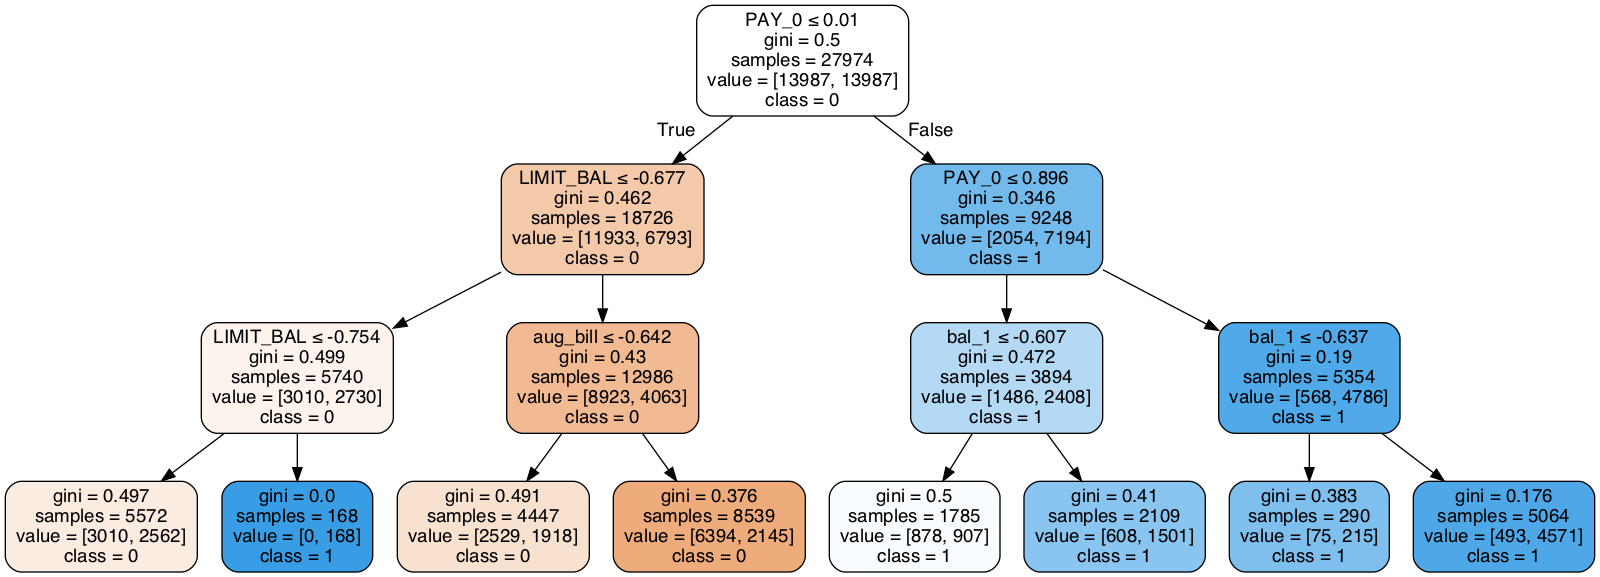

In [229]:
dot_data = StringIO()
export_graphviz(grid_tree.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = df_lab.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('titanic_gs.png')
Image(graph.create_png())

In [232]:

from sklearn.metrics import make_scorer, accuracy_score #Import scikit-learn metrics module for accuracy calculation

# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid= parameters,
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_

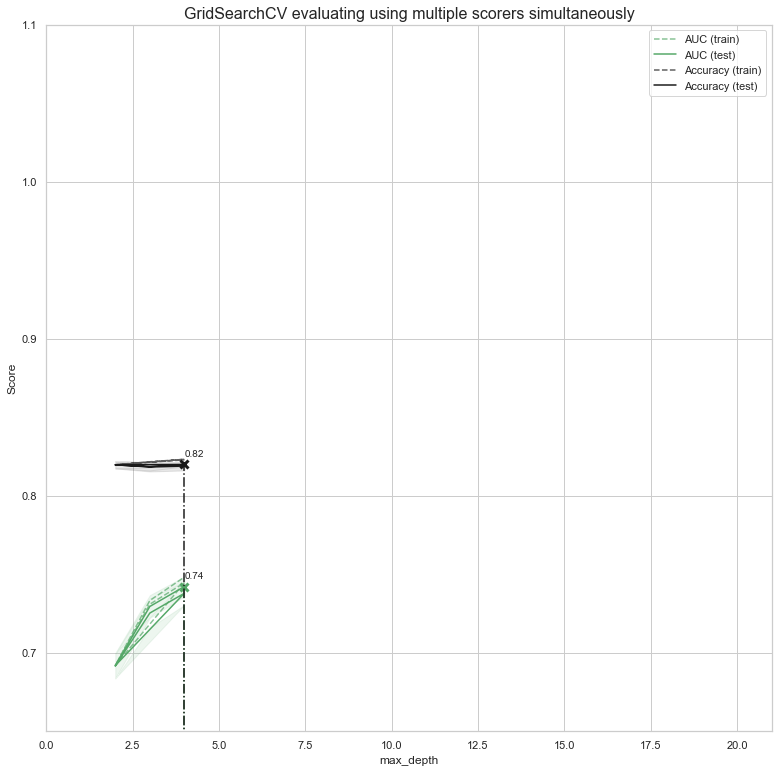

In [234]:
import numpy as np
from matplotlib import pyplot as plt



plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("max_depth")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 21)
ax.set_ylim(0.65, 1.1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show();